# Object detection lab

Understand the intuition behind object detection here:

- http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ssearch_schuyler.pdf


- [A Step-by-Step Introduction to the Basic Object Detection Algorithms (Part 1)](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)
- [A Practical Implementation of the Faster R-CNN Algorithm for Object Detection (Part 2 – with Python codes)
](https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/)
- [A Practical Guide to Object Detection using the Popular YOLO Framework – Part III (with Python codes)](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/)

In [50]:
from libraries import detection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib.patches import Rectangle 
from skimage.transform import resize
import mlutils

In [51]:
def show_boxes(img, boxes):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.imshow(img)
    for i in range(len(boxes)):
        b = boxes[i]
        w,h = b[2]-b[0], b[3]-b[1]
        if w*h<100:
            continue
        rect = Rectangle((b[0],b[1]), w, h, linewidth=2, edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    

## Running selective seearch

observe how selective search computes a set of suggested boxes possibly containing objects.

inspect the contents of the numpy array with the selected boxes.

In [52]:
img = plt.imread("Images/cars-driving.jpg")
bb = detection.selective_search(img, ks=[700])
print bb.shape

. . . . (40, 4)


In [53]:
print bb

[[  0.   0. 492. 277.]
 [  0.  92. 492. 277.]
 [  0.  13. 492. 277.]
 [  0.   0. 492. 159.]
 [  0.  65. 492. 277.]
 [  0.  19. 492. 159.]
 [264.  26. 492. 147.]
 [264.  68. 438. 147.]
 [138.  73. 357. 161.]
 [  0.   0. 492.  82.]
 [  0.  93. 492. 277.]
 [183.  73. 357. 153.]
 [  0.   0. 385.  56.]
 [  0.  92. 119. 190.]
 [  0.  19. 406. 159.]
 [378.  26. 492. 128.]
 [183.  92. 305. 153.]
 [396.  82. 438. 131.]
 [310.   0. 492.  82.]
 [  0. 114. 492. 277.]
 [156. 136. 475. 277.]
 [241.   0. 385.  56.]
 [264.  68. 414. 147.]
 [  0.   0. 492.  80.]
 [  0.   0. 304.  56.]
 [201.  73. 357. 147.]
 [276.  73. 357. 147.]
 [201.  76. 284. 113.]
 [278.  73. 357. 113.]
 [372.  65. 492. 132.]
 [  0.  13. 492. 154.]
 [310.   0. 492.  80.]
 [183.  93. 301. 153.]
 [  0.   0. 383.  55.]
 [  0. 106. 108. 138.]
 [276.  96. 352. 147.]
 [  0. 120. 492. 277.]
 [  0. 142. 103. 191.]
 [  0. 186. 223. 233.]
 [138. 125. 268. 161.]]


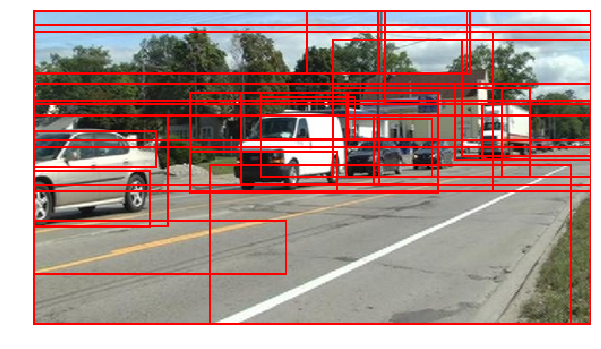

In [54]:
show_boxes(img, bb)

## Part 1: Run pretrained alexnet finetuned model on patches

- load the alexnet finetuned model obtained in the Transfer Learning notes
- for each box extract a patch from the image
- resize all patches, use [skimage.transform.resize](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize)
- run the model
- select the patches with class **car**
- show all boxes with car detections
- do not include patches with small areas (less than 100 px^2)

To run the model your are suggested to:

- first gather all resized patches in a single array
- call only once `model.predict`

Observe that the `predict` function on the model will yield the class probabilities. Simply select the class with highest proabability on each image.

You may get something like the following image, with the **car** patches overimposed. You result might differ.

![](./Images/lab_dectection_02.png)

In [55]:
## load model

from tensorflow.keras.models import load_model

model = load_model("alexnet_finetuned_minicifar.model")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
__________

make list of patches from selective search boxes

In [57]:
rpatches = []
for i in mlutils.pbar()(range(len(bb))):
    l = abs(int(bb[i][1]) - int(bb[i][3])) 
    a = abs(int(bb[i][0]) - int(bb[i][2]))
    if l*a>100:
        rs = resize(img[int(bb[i][1]):int(bb[i][3]),int(bb[i][0]):int(bb[i][2])],(32,32))
        rpatches += [rs]


100% (40 of 40) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [11]:
rboxes = np.r_[rpatches]
rboxes.shape

(40, 32, 32, 3)

get the model class predictions (you will get probabilities and need to transform them to classes)

In [12]:
bpreds = model.predict(rboxes).argmax(axis=1)


select the predictions with cars

In [13]:
bcars = bb[bpreds==1]
bcars.shape

(13, 4)

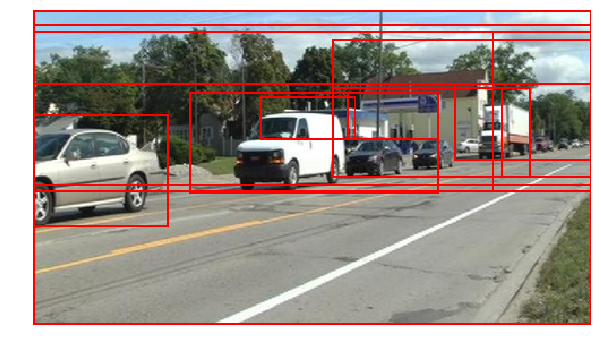

In [14]:
show_boxes(img, bcars)

## Part 2: Devise some strategy to filter and merge patches

- remove patches that intersect with many (likely to be too large)
- remove patches that intersect with too few (objects are likely to produce several patches)
- merge patches that overlap more than 50% of any of the two
- any other strategy you might devise

Observe that your result **will not be perfect**. This is OK, since we are using a classifier trained with a small dataset.

This is a possible outcome

![](./Images/lab_dectection_01.png)

In [47]:
automovil=[]
for i in range(len(bcars)):
    l = abs(int(bcars[i][1]) - int(bcars[i][3])) 
    a = abs(int(bcars[i][0]) - int(bcars[i][2]))
    if l>50 and l<200 and a>100 and a<250:
        automovil += [bcars[i]]



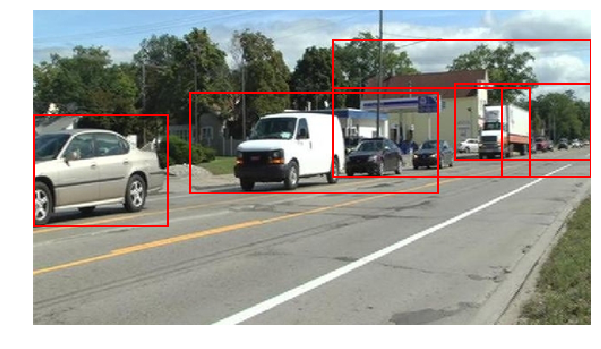

In [48]:
show_boxes(img, automovil)